# CS 598 Deep Learning for Healthcare Final Project Draft 
Paper: Anticancer drug synergy prediction in understudied tissues using transfer learning

# Introduction 

- Background of The Problem

One promissing area of research is the prediction of anticancer drug synergy. Drug synergy occurs when the combined effect of two drugs exceeds the sum of their individual effects, potentially leading to more effective cancer treatment with few side effects. However, finding good drug combinations to treat cancer better is tough because we don't have enough test results for all cancer types. Some cancers may have been studied a lot, and we know how they react to drugs. But many other cancers haven't been looked at as much, so it's hard to know what drug combinations might work best for them. We want to fix this by using a special method to guess the effects of drugs on these less-studied cancers, using what we've learned from the cancers we know more about.

The Problem at hand is a complex mixture of disease prediction, feature engineering, and data processing. It involves predicting which combinations of drugs might work synergistically for cancer treatment in specific tissues, using computational models to analyze vast datasets of molecular, genetic, and phenotypic features of cancer cell lines. Solving this problem has the potential to revolutionize cancer treatment by identifying new drug combinations that are highly effective against cancer cells while minimizing harm to normal cells. This could lead to more personalized and effective treatment plans, especially for cancers that are currectly difficult to treat.

The prediction of drug synergy in understudied tissues is fraught with challenges, primarily due to the scarcity of data. Many tissues have not been thoroughly researched, resulting in a limited understanding of their response to various drug treatments. Moreover, the high dimensionality of the data, the need for accurate feature selection, and the complexity of cancer biology add layers of complexity to developing predictive models. The paper discusses a new approach that utilizes multitask deep neural networks and transfer learning from data-rich tissues to enhance the prediction accuracy in data-poor tissues. This method not only improves the accuracy of predictions in both data-rich and understudied tissues but also opens up new avenues for prioritizing future experimental investigations.

- Paper explanation

This research paper presents a new way to find out which two drugs can work better together to treat cancer, especially in parts of the body not much studied before. It talks about using transfer learning, to better predict on how drug combinations work in tissues that scientists haven't been able to explore much. The paper's method takes well-studied parts of the body and uses that knowledge to make educated predict about less-known areas. It mixes a bunch of information about cancer cells, like their genes and how they look, with a clever computer brain that can handle multiple tasks at once. This is quite different because it tries to solve the problem of not having enough data about some types of cancer.

The model achieved high scores in AUROC (Area Under the Receiver Operating Characteristic curve) and MSE (Mean Squared Error), indicative of its precision and reliability. The improved accuracy in data-poor environments, highlights the method of using transfer learning and multitask deep neural networks to overcome the challenges posed by data scarcity. This paper helps better about which drug combinations might be a winning team against cancer in parts of the body that we don't know much about. This could lead to discovering new treatments faster and more cheaply, making a big difference in the fight against cancer.

# Scope of Reproducibility:

- Hypothesis 1: The transfer learning approach can significantly improve the accuracy of drug synergy predictions in understudied tissues
- Hypothesis 2: A model trained on data-rich tissues can effectively learn generalizable patterns applicable to data-poor tissues.

# Methodology 

In [2]:
import sys
print(sys.version)

3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]


In [78]:
import os
import torch
import numpy as np
import pandas as pd
import pdb
import time
import pickle
import logging
import matplotlib.pyplot as plt
from utilities import Mapping

In [79]:
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [80]:
bsz = 128
device = 3
#torch.cuda.set_device(device)

device = torch.device("cpu")
num_gene_compressed_drug = 64
num_gene_compressed_cell = 128

isClassification=True #False for regression task
syn_threshold = 30
ri_threshold = 50

batch_first=True
log_interval = 100
epochs = 10

# Data

Data Preprocessing:

- Drug Sensitivity and Synergy : The raw data was collected from DrugComb and loaded from a CSV file, summary_table_v1.4.csv(https://drugcomb.org/download/). It contains the experimental results, including the drug pair identifiers (drug_row and drug_col), the cell line names, and the observed effects.A mapping is created from study_name to a unique number for study_id and apply the mapping to the 'study_name' column to create a new 'study_id' column. To reduce variance and simplify the dataset, the mean values were computed for each combination of drug_row, drug_col, cell_line_name, and study_id, and only retain the relevant features. A unique index was assigned to each drug and cell line name using a custom Mapping class.

- Drug Features: The raw data of drug features was provided by author Yejin Kim directly.The preprocessing of the drug dataset was a multi-step process that involved cleaning, transforming, and merging data from various sources to create drug’s molecular and genomic features. After loading the drug data, the column named 'pubchem_cid' was renamed to 'cid', each drug's name was translated into a numerical identifier using a predefined mapping and rows with missing 'id' values were filtered out. The 'smiles' strings, representing the structural formula of drugs, were converted into MACCS keys and then converting each character into a numerical index. In addition, target genes from DrugBank were loaded and grouped by 'drugbank_id' to remove duplicates and aggregate the data then merged back into the main drug dataset.

- Cell Line Features: The raw data of cell features was provided by author Yejin Kim directly. Started by loading the metadata for cell lines from a CSV file, any redundant or unnecessary columns were removed and converted categorical data into numerical codes. I further annotated each cell line with information regarding the tissue and disease it was associated with, and performed joins where necessary. The gene expression levels of the cell lines were integrated from multiple sources. The datasets from Broad and SANGER were combined, and standard deviation filtering was applied to remove genes that did not vary across the dataset. Z-score normalization gene-wise was performed to adjust for the mean and standard deviation of each gene's expression levels across all cell lines. If genes with a standard deviation of zero, were excluded.

- Data_Preprocess.ipyb can be found at the github (https://github.com/aariel-chen/CS598-Final-Project/tree/master)


Our final dataset consists of experimental synergy scores along with associated drug and cell line features. The dataset includes a total of 288 unique cell lines and 4268 unique drugs, each drug is described by a set of molecular fingerprints (fps) and SMILES strings, with the latter having a maximum length of 364 characters. For the cell lines, gene expression profiles are provided, with each cell line associated with a specific tissue and disease, encoded numerically as tissue_id and disease_id respectively, with 24356 unique genes represented across the cell lines. 


In [6]:
summary = pickle.load(open('summary_mean.p', 'rb'))
codes = pickle.load(open('codes.p', 'rb'))

In [7]:
summary

,drug_row,drug_col,cell_line_name,study_id,ri_row,ri_col,synergy_loewe
0,4065,274,0,12,-21.079400,17.392589,4.436431
1,2224,1810,1,23,-20.043000,25.595000,-44.555935
2,2224,493,1,23,-9.776000,29.111000,-37.189720
3,1717,274,0,12,-4.051616,17.392589,10.755529
4,1551,2949,2,5,1.966000,25.537000,-8.644502
...,...,...,...,...,...,...,...
651163,4166,4243,42,21,18.700184,19.589164,-10.017628
651164,4166,3502,42,21,18.700184,22.609164,6.530700
651165,4166,2607,42,21,18.700184,36.179164,6.099381
651166,4166,1759,42,21,18.700184,96.809164,-4.284099


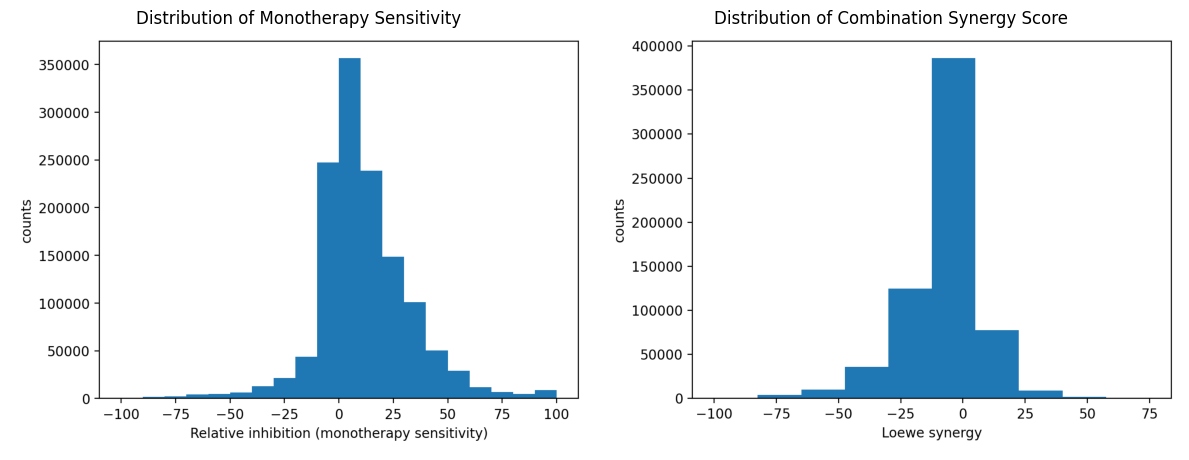

In [8]:
img1 = mpimg.imread('ri_cnt.png')  # Update with the path to your first image
img2 = mpimg.imread('syn_cnt.png')  # Update with the path to your second image

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first image
axes[0].imshow(img1)
axes[0].set_title('Distribution of Monotherapy Sensitivity')
axes[0].axis('off')

# Plot the second image
axes[1].imshow(img2)
axes[1].set_title('Distribution of Combination Synergy Score')
axes[1].axis('off')  

# Display the plot
plt.tight_layout()
plt.show()

In drug efficacy studies, synergy score is used to understand how different drug combinations or dosages affect the inhibition of cell growth. Values greater than zero on the x-axis indicate that combination therapy is more effective than monotherapy, as it leads to higher inhibition. Conversely, values less than zero would suggest that monotherapy is relatively more effective. 

In [9]:
missing_in_drug_row = summary['drug_row'].isna().any()
missing_in_drug_col = summary['drug_col'].isna().any()
print(missing_in_drug_row)
print(missing_in_drug_col)

False
False


In [10]:
# Drug features
drug_features = pickle.load(open('drug_features.p', 'rb'))
drug_features

,smiles,fps,gene_id
id,,,
1,"[24, 5, 28, 24, 24, 28, 24, 29, 24, 28, 24, 5,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11961, 7269, 21906, 5278, 22355, 2852, 7649, ..."
4,"[24, 24, 5, 28, 24, 29, 24, 29, 28, 24, 24, 28...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5461, 11980, 19874, 22608]"
7,"[24, 24, 29, 24, 5, 28, 24, 24, 28, 24, 24, 28...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[]
10,"[24, 5, 24, 29, 24, 27, 5, 24, 29, 28, 32, 35,...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",[]
32,"[24, 27, 5, 24, 17, 24, 24, 24, 5, 24, 24, 29,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11961, 23506, 22608, 4594, 22640, 7649, 3348,..."
...,...,...,...
4214,"[24, 24, 5, 28, 24, 29, 26, 24, 29, 28, 27, 5,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11961, 4594, 20873, 15614, 22986, 21906, 7524..."
4223,"[24, 24, 29, 24, 5, 28, 24, 24, 28, 24, 24, 28...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[19030]
4237,"[24, 32, 24, 5, 28, 24, 29, 24, 28, 24, 17, 24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[20181, 3762, 22292, 22381]"


In [11]:
missing_in_drug_fps = drug_features['fps'].isna().any()
missing_in_drug_smiles = drug_features['smiles'].isna().any()
print(missing_in_drug_fps)
print(missing_in_drug_smiles)

False
False


In [12]:
# Cell line features
cell_features = pickle.load(open('cell_features.p', 'rb'))
cell_features

,tissue_id,disease_id,gene_id
cell_id,,,
0,0,0,"{23059: 0.06775902532313936, 14106: -0.1630840..."
1,1,1,{}
2,2,2,"{23059: 0.06775902532313936, 14106: -0.1630840..."
3,1,3,"{23059: 0.7631806010079909, 14106: -0.16308409..."
4,0,4,{}
...,...,...,...
267,13,41,"{23059: -0.6276625503617121, 14106: -0.1630840..."
270,6,16,"{23059: -0.6276625503617121, 14106: 0.95931818..."
280,16,51,"{23059: -0.6276625503617121, 14106: -0.1630840..."


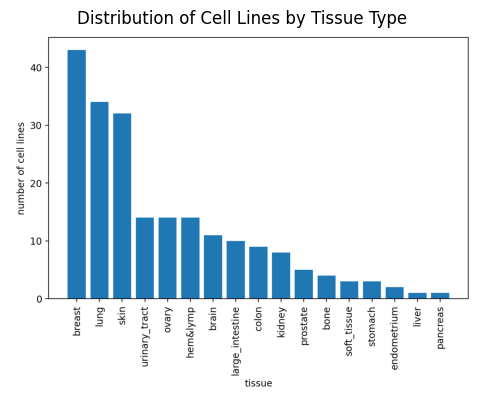

In [13]:
img = mpimg.imread('tissue_num_cell.png')
plt.figure(figsize=(6,6)) 
plt.imshow(img)
plt.title('Distribution of Cell Lines by Tissue Type')
plt.axis('off')
plt.show()

Data-rich tissues include hematopoietic and lymphoid, lung, skin, ovary, kidney, brain, breast, and colon, which have more than 20 000 drug combination tests with more than 5 different cell lines per each tissue. Data-poor tissues include prostate and bone, which have less than 15 000 drug combination tests within less than 3 cell lines per tissues.

In [14]:
missing_in_cell_tissue = cell_features['tissue_id'].isna().any()
missing_in_cell_disease = cell_features['disease_id'].isna().any()
print(missing_in_cell_tissue)
print(missing_in_cell_disease)

False
False


In [48]:
num_celllines = len(codes['cell'].idx2item)
num_drugs = len(codes['drugs'].idx2item)
num_genes = len(codes['gene'].idx2item)
num_tissue = len(codes['tissue'].idx2item)
num_disease = len(codes['disease'].idx2item)
num_drug_fp = len(drug_features.iloc[0]['fps'])
max_drug_sm_len = drug_features['smiles'].apply(lambda x: len(x)).max()

print(f"Summary of Dataset:")
print(f"Number of Cell Lines: {num_celllines}")
print(f"Number of Drugs: {num_drugs}")
print(f"Number of Genes: {num_genes}")
print(f"Number of Tissues: {num_tissue}")
print(f"Number of Diseases: {num_disease}")
print(f"Number of Drug Fingerprints: {num_drug_fp}")
print(f"Maximum SMILES String Length: {max_drug_sm_len}")

Summary of Dataset:
Number of Cell Lines: 288
Number of Drugs: 4268
Number of Genes: 24356
Number of Tissues: 17
Number of Diseases: 52
Number of Drug Fingerprints: 167
Maximum SMILES String Length: 364


In [49]:
summary_filtered = summary[
    summary['drug_row'].isin(drug_features.index) & 
    summary['drug_col'].isin(drug_features.index) &
    summary['cell_line_name'].isin(cell_features.index)
].reset_index(drop=True)

In [17]:
d1 = summary_filtered.iloc[100,0]

In [18]:
np.array(drug_features.loc[d1, 'fps'])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

# Gene Compression - Dataset and DataLoader

In [19]:
class DrugTargetDataset(Dataset):
    def __init__(self, drug_features):
        self.drug_features = drug_features
        self.drug_features.reset_index(drop=True, inplace=True)
        
    def __len__(self):
        return len(self.drug_features)
        
    def __getitem__(self,idx):
        gene_ids = self.drug_features.loc[idx, 'gene_id']
        genes = np.zeros(num_genes)
        genes[gene_ids] = 1      
        return genes
    
class CellGeneDataset(Dataset):
    def __init__(self, cell_features):
        self.cell_features = cell_features
        
    def __len__(self):
        return len(self.cell_features)
        
    def __getitem__(self,idx):
        gene_ids = self.cell_features.loc[idx,'gene_id']
        genes = np.zeros(num_genes)
        for key,value in gene_ids.items():
            genes[key] = value
            
        return genes

In [20]:
#Two layers of fully connected layers
class FC2(nn.Module):
    def __init__(self, in_features, out_features, dropout):
        super(FC2, self).__init__()
        
        self.bn = nn.BatchNorm1d(in_features)
        self.fc1 = nn.Linear(in_features, int(in_features/2))
        self.fc2 = nn.Linear(int(in_features/2),out_features)
        self.dropout = nn.Dropout(dropout)
                
    def forward(self, x):
        x = self.bn(x)
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# Compress Gene Features

In [21]:
class GeneCompressor(nn.Module):
    def __init__(self, num_in, num_out, dropout=0.1):
        super(GeneCompressor, self).__init__()
        self.dropout = dropout
        self.encoder = nn.Linear(num_in, num_out)
        self.decoder = nn.Linear(num_out,num_in)

    def _encoder(self,x):
        return F.dropout(F.relu(self.encoder(x)), self.dropout, training=self.training)
    
    def _decoder(self,x):
        return F.dropout(self.decoder(x), self.dropout, training=self.training)
    
    def forward(self, x):
        x = self._encoder(x)
        x = self._decoder(x)
        return x
        
    def encode_genes(self, genes):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # No need to track gradients
            encoded_genes = self._encoder(genes)
        return encoded_genes.cpu().data.numpy()

In [22]:
def geneCompressing(data_loader,num_gene_compressed, noise_weight=0.2, epochs=20, log_interval=10 ):
    #model
    geneCompressor = GeneCompressor(num_genes, num_out=num_gene_compressed, dropout=0.1)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(geneCompressor.parameters())

    for epoch in range(1, epochs + 1):
        #train
        geneCompressor.train()
        total_loss = 0
        start_time = time.time()
        for iteration, gene in enumerate(data_loader):
            gene = Variable(gene).float()
            noise = noise_weight*torch.randn(gene.shape)

            optimizer.zero_grad()
            output = geneCompressor(gene+noise)
            loss = criterion(output,gene)
            loss.backward()
            optimizer.step()
            total_loss += loss.data
            
            if iteration % log_interval == 0 and iteration > 0:
                cur_loss = total_loss.item() / log_interval
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:8.5f}'.format(epoch, iteration, int(len(data_loader)/bsz), elapsed * 1000/log_interval, cur_loss))
                total_loss = 0
                start_time = time.time()
        '''        
         #test
    geneCompressor.eval()
    total_loss = 0
    start_time = time.time()
    with torch.no_grad():
        for iteration, gene in enumerate(test_data_loader):
            gene = Variable(gene).float()
            output = geneCompressor(gene)
            loss = criterion(output,gene)
            total_loss += loss.data
        print(total_loss.item()/iteration)
      '''       
    return geneCompressor

In [23]:
#drug's target gene data
drugGeneDataset = DrugTargetDataset(drug_features)
drugGeneDataset_loader = DataLoader(drugGeneDataset, batch_size=64, shuffle=True)

#learn
drugGeneCompressor = geneCompressing(drugGeneDataset_loader, num_gene_compressed_drug)

#save
drugGeneCompressor.eval()
drugGeneCompressed = np.array([drugGeneCompressor.encode_genes(torch.FloatTensor(drugGeneDataset[d])) for d in range(len(drugGeneDataset))])
torch.save(drugGeneCompressor.state_dict(), 'drugGeneCompressor.p')
pickle.dump(drugGeneCompressed, open('drugGeneCompressed.p', 'wb'))

In [24]:
drugGeneCompressed = pickle.load(open('drugGeneCompressed.p', 'rb'))
drugGeneCompressed = torch.FloatTensor(drugGeneCompressed)

In [25]:
#cell line's gene expression data
cell_features.reset_index(drop=True, inplace=True)
cellGeneDataset = CellGeneDataset(cell_features)
cellGeneDataset_loader = DataLoader(cellGeneDataset, batch_size=64, shuffle=True)

#learn
cellGeneCompressor=geneCompressing(cellGeneDataset_loader,num_gene_compressed_cell, noise_weight=0.01, log_interval=1 )

#save
cellGeneCompressor.eval()
cellGeneCompressed = np.array([cellGeneCompressor.cpu()._encoder(torch.FloatTensor(cellGeneDataset[d])).data.numpy() for d in range(len(cellGeneDataset))])
torch.save(cellGeneCompressor.state_dict(), 'cellGeneCompressor.p')
pickle.dump(cellGeneCompressed, open('cellGeneCompressed.p', 'wb'))

| epoch   1 |     1/    0 batches | ms/batch 549.99 | loss  2.56841
| epoch   1 |     2/    0 batches | ms/batch 274.32 | loss  1.64460
| epoch   1 |     3/    0 batches | ms/batch 128.82 | loss  2.07364
| epoch   2 |     1/    0 batches | ms/batch 546.82 | loss  3.29773
| epoch   2 |     2/    0 batches | ms/batch 281.07 | loss  1.99038
| epoch   2 |     3/    0 batches | ms/batch 91.86 | loss  1.88550
| epoch   3 |     1/    0 batches | ms/batch 516.67 | loss  3.05067
| epoch   3 |     2/    0 batches | ms/batch 287.37 | loss  2.26329
| epoch   3 |     3/    0 batches | ms/batch 97.91 | loss  1.47983
| epoch   4 |     1/    0 batches | ms/batch 579.77 | loss  2.90889
| epoch   4 |     2/    0 batches | ms/batch 249.99 | loss  1.62934
| epoch   4 |     3/    0 batches | ms/batch 108.08 | loss  1.14370
| epoch   5 |     1/    0 batches | ms/batch 551.25 | loss  2.71345
| epoch   5 |     2/    0 batches | ms/batch 255.15 | loss  1.26369
| epoch   5 |     3/    0 batches | ms/batch 125.8

In [26]:
cellGeneCompressed = pickle.load(open('cellGeneCompressed.p', 'rb'))
cellGeneCompressed = torch.FloatTensor(cellGeneCompressed)

- Train/test split in cross or external validation

In [27]:
def get_cell_of_interest(tissues):
    tissues_of_interests = [codes['tissue'].item2idx[minor_tissue] for minor_tissue in tissues]
    cell_of_interest = cell_features.index[cell_features['tissue_id'].isin(tissues_of_interests)].tolist()
    return cell_of_interest

- Train/test for general model



In [66]:
minor_tissues = ['kidney', 'prostate' ]
cell_of_interest = get_cell_of_interest(minor_tissues)
df_tissue_of_interest = summary_filtered.loc[summary_filtered['cell_line_name'].isin(cell_of_interest),:]
df_all = summary_filtered.drop(df_tissue_of_interest.index)
#specific database
#df_all = df_all.loc[df_all['study_id']==3]

#cross validation
df_train, df_test = train_test_split(df_all, test_size=0.3) 

#external validation
df_train_almana = df_all
df_test_almana = df_all.loc[df_all['study_id']!=3] 

df_train_oneil = df_all
df_test_oneil = df_all.loc[df_all['study_id']!=28] 
#df_train = df_all.loc[df_all['study_id']==3] 3: 'ALMANAC'
#df_test = df_all.loc[df_all['study_id']==1] 1: 'ONEIL'

* Train/test for kidney

In [75]:
_df_kidney = summary_filtered.loc[summary_filtered['cell_line_name'].isin(get_cell_of_interest(['kidney'])),:]
# Cross validation
_df_train_kidney, _df_test_kidney = train_test_split(_df_kidney, test_size=0.2, random_state=1)

# External validation
_df_train_kidney_ex =_df_kidney
_df_test_kidney_ex = _df_kidney.loc[_df_kidney['study_id']!=9]
#_df_train_bone_ex=_df_bone.loc[_df_bone['study_id']!=9]
#_df_test_bone_ex= _df_bone.loc[_df_bone['study_id']==9]

* Train/test for prostate



In [84]:
_df_prostate= summary_filtered.loc[summary_filtered['cell_line_name'].isin(get_cell_of_interest(['prostate'])),:]

#Cross validation
_df_train_prostate, _df_test_prostate = train_test_split(_df_prostate, test_size=0.2, random_state=1)

# External validation
_df_train_prostate_ex =_df_prostate
_df_test_prostate_ex =_df_prostate.loc[_df_prostate['study_id']!=31]

#_df_train_prostate=_df_prostate.loc[_df_prostate['study_id']!=1]
#_df_test_prostate=_df_prostate.loc[_df_prostate['study_id']==1]

# Dataset and Dataloader

In [29]:
class DrugCombDataset(Dataset):
    def __init__(self, summary_filtered, drug_features, cell_features):
        self.summary_filtered = summary_filtered
        self.summary_filtered.reset_index(drop=True, inplace=True)
        
        self.drug_features = drug_features
        self.drug_features.reset_index(drop=True, inplace=True)
        
        self.cell_features = cell_features
        self.cell_features.reset_index(drop=True, inplace=True)

    def __len__(self):
        return len(self.summary_filtered)
    
    def __getitem__(self, idx):
        
        d1 = self.summary_filtered.iloc[idx, 0]
        d2 = self.summary_filtered.iloc[idx, 1]
        cell = self.summary_filtered.iloc[idx,2]
        ri_d1 = 1.0 if self.summary_filtered.iloc[idx,3] >ri_threshold else 0
        ri_d2 = 1.0 if self.summary_filtered.iloc[idx,4] >ri_threshold else 0
        syn = 1.0 if self.summary_filtered.iloc[idx, 5] >syn_threshold else 0
        
        
        #external features
        d1_fp = np.array(self.drug_features.loc[d1, 'fps'])
        d1_sm = self.drug_features.loc[d1, 'smiles']
        d1_sm = np.pad(d1_sm, pad_width=(0, max_drug_sm_len-len(d1_sm)), mode='constant', constant_values=0)
        d1_gn=drugGeneCompressed[d1]
        
        d2_fp = np.array(self.drug_features.loc[d2, 'fps'])
        d2_sm = self.drug_features.loc[d2, 'smiles']
        d2_sm = np.pad(d2_sm, pad_width=(0, max_drug_sm_len-len(d2_sm)), mode='constant', constant_values=0)
        d2_gn=drugGeneCompressed[d2]
        
        c_ts = self.cell_features.iloc[cell]['tissue_id']
        c_ds = self.cell_features.iloc[cell]['disease_id']
        c_gn = cellGeneCompressed[cell]
        
        
        sample = {
            'd1': d1,
            'd1_fp': d1_fp,
            'd1_sm': d1_sm,
            'd1_gn': d1_gn,
            
            'd2': d2,
            'd2_fp': d2_fp,
            'd2_sm': d2_sm,
            'd2_gn': d2_gn,
            
            'cell': cell,
            'c_ts': c_ts,
            'c_ds': c_ds, #missing -1
            'c_gn': c_gn,
            
            'ri_d1': ri_d1,
            'ri_d2': ri_d2,
            'syn': syn
        }
        
        return sample

- General model datasets

In [67]:
train = DrugCombDataset(df_train, drug_features, cell_features)
train_loader = DataLoader(train, batch_size=bsz, shuffle=True )
test = DrugCombDataset(df_test, drug_features, cell_features)
test_loader = DataLoader(test, batch_size=bsz, shuffle=True )

In [61]:
train_almana = DrugCombDataset(df_train_almana, drug_features, cell_features)
train_almana_loader = DataLoader(train_almana, batch_size=bsz, shuffle=True )
test_almana = DrugCombDataset(df_test_almana, drug_features, cell_features)
test_almana_loader = DataLoader(test_almana, batch_size=bsz, shuffle=True )

In [63]:
train_oneil = DrugCombDataset(df_train_oneil, drug_features, cell_features)
train_oneil_loader = DataLoader(train_oneil, batch_size=bsz, shuffle=True )
test_oneil = DrugCombDataset(df_test_oneil, drug_features, cell_features)
test_loader_oneil = DataLoader(test_oneil, batch_size=bsz, shuffle=True )

* Bone

In [76]:
_train_kidney = DrugCombDataset(_df_train_kidney, drug_features, cell_features)
_train_loader_kidney = DataLoader(_train_kidney, batch_size=bsz, shuffle=True )
_test_kidney = DrugCombDataset(_df_test_kidney, drug_features, cell_features)
_test_loader_kidney = DataLoader(_test_kidney, batch_size=bsz, shuffle=False )

In [82]:
_train_kidney_ex = DrugCombDataset(_df_train_kidney_ex, drug_features, cell_features)
_train_loader_kidney_ex = DataLoader(_train_kidney, batch_size=bsz, shuffle=True )
_test_kidney_ex = DrugCombDataset(_df_test_kidney_ex, drug_features, cell_features)
_test_loader_kidney_ex = DataLoader(_test_kidney_ex, batch_size=bsz, shuffle=False )

* Prostate

In [85]:
_train_prostate = DrugCombDataset(_df_train_prostate, drug_features, cell_features)
_train_loader_prostate = DataLoader(_train_prostate, batch_size=bsz, shuffle=True )
_test_prostate = DrugCombDataset(_df_test_prostate, drug_features, cell_features)
_test_loader_prostate = DataLoader(_test_prostate, batch_size=bsz, shuffle=False )

In [87]:
_train_prostate_ex = DrugCombDataset(_df_train_prostate_ex, drug_features, cell_features)
_train_loader_prostate_ex = DataLoader(_train_prostate_ex, batch_size=bsz, shuffle=True )
_test_prostate_ex = DrugCombDataset(_df_test_prostate_ex, drug_features, cell_features)
_test_loader_prostate_ex = DataLoader(_test_prostate_ex, batch_size=bsz, shuffle=False )

# Prediction model

- Citation to the Original Paper
  
Kim, Y., Zheng, S., Tang, J., Zheng, W.J., Li, Z., & Jiang, X. (2021). Anticancer drug synergy 
prediction in understudied tissues using transfer learning. Journal of the American Medical 
Informatics Association https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7810460/

- Link to the original paper’s repo : https://github.com/yejinjkim/synergy-transfer

The drug synergy prediction model is a deep neural network designed to estimate whether unobserved drug combinations have synergistic effects in a given cell line and to provide a list of combinations. The model incorporates a drug encoder and a cell line encoder. The model can capture the non-linear and complex relationships within the data using embeddings and convolutions, and the transformer architecture also helps in handling sequence data effectively.

(1) The drug encoder deals with molecular and genomic features of drugs, such as MACCS fingerprints and SMILES representations. Linear transformation is applied to both the molecular fingerprints and genomic features.
(2) Similarly, the cell line encoder processes features like cancer type and gene expressions. It uses embeddings to convert categorical data such as tissue and disease types into dense vector representations. After encoding, the representations from the drug encoder and the cell line encoder are merged and fed into a series of neural network layers. This model uses a Transformer architecture, a type of model widely used in natural language processing, to handle the sequential nature of the SMILES representation of chemical compounds.
(3) The Comb class combines the features from the DrugEncoder and CellEncoder. The forward method takes a list of drug features (d1_list, d2_list) and cell line features (c_list), passing them through the corresponding encoder. Then the concatenated drug features are passed through a fully connected layer (fc_syn) to predict synergy scores and the concatenated cell line features are passed through another fully connected layer (fc_ri) to predict response indicators.

In [31]:
class DrugEncoder(nn.Module):
    def __init__(self,
                 num_drugs=num_drugs,
                 num_ID_emb=0,
                 num_drug_fp=num_drug_fp,
                 max_drug_sm_len=max_drug_sm_len,
                 num_gene = num_gene_compressed_drug,
                 num_comp_char=len(codes['mole'].idx2item),
                 fp_embed_sz = 32,
                 gene_embed_sz = int(num_gene_compressed_drug/2),
                 out_size=64,
                 dropout=0.3):
        super(DrugEncoder, self).__init__()
        
        self.dropout= dropout
        #DRUG
        #drug ID
        #self.embed_id = nn.Embedding(num_drugs, num_ID_emb)
        
        #compound ID
        self.embed_comp = nn.Embedding(num_comp_char, num_comp_char, padding_idx=0)#padding's idx=0
        #encoding compound
        self.encoderlayer = nn.TransformerEncoderLayer(d_model=num_comp_char, nhead=2)
        self.encoder = nn.TransformerEncoder(self.encoderlayer, num_layers=1)
        
        #fingerprint
        self.dense_fp = nn.Linear(num_drug_fp,fp_embed_sz)
        #gene
        self.dense_gene = nn.Linear(num_gene,gene_embed_sz)
        
        #depthwise for compound encoding
        self.conv = nn.Conv2d(1, 1, (1, num_comp_char), groups=1)
        
        #combined
        combined_sz = num_ID_emb+fp_embed_sz+max_drug_sm_len+gene_embed_sz
        self.FC2 = FC2(combined_sz, out_size, dropout)

    def forward(self, d_list):
        """
            id: bsz*1
            fp: bsz*num_drug_fp
            sm: bsz*max_drug_sm_len
        """
        id, fp, sm, gn = d_list
        
        sm = self.embed_comp(sm) #bsz*max_drug_sm_len*num_comp_char(embedding size)
        sm = self.encoder(sm)
        sm = self.conv(sm.unsqueeze(1)).squeeze()
        
        fp = F.relu(self.dense_fp(fp))
        gn = F.relu(self.dense_gene(gn))
        
        #combine
        x = torch.cat((fp, sm, gn),1) # bsz*[num_emb_id+num_drug_fp+max+drug_sm]
        x = self.FC2(x)
        
        return x

In [32]:
class CellEncoder(nn.Module):
    def __init__(self,
                 num_cells=num_celllines,
                 num_tissue=0,
                 num_disease=num_disease,
                 num_ID_emb=0,
                 gene_embed_sz=int(num_gene_compressed_cell/2),
                 num_gene=num_gene_compressed_cell,
                 out_size=64,
                 dropout=0.3):
        super(CellEncoder, self).__init__()
        
        self.dropout= dropout
        #cell ID
        #self.embed_id = nn.Embedding(num_cells, num_ID_emb)
        #cell tissue
        #self.embed_ts = nn.Embedding(num_tissue, num_tissue)
        #cell disease
        self.embed_ds = nn.Embedding(num_disease, num_disease, padding_idx=3)
        #gene
        self.dense_gene = nn.Linear(num_gene,gene_embed_sz)
        
        #combined
        combined_sz = num_ID_emb+num_tissue+num_disease+gene_embed_sz
        self.FC2 = FC2(combined_sz, out_size, dropout)
    
        
    def forward(self, c_list):
        """
            id: bsz*1
            fp: bsz*num_drug_fp
            sm: bsz*max_drug_sm_len
        """
        id, ts, ds, gn = c_list
        ds = F.relu(self.embed_ds(ds)) #bsz*num_diesaes
        
        gn = F.relu(self.dense_gene(gn)) #bsz*gene_embed_sz
        
        #combine
        
        x = torch.cat((ds, gn),1) # bsz*combined_sz
        x = self.FC2(x)

        return x
        

In [33]:
class Comb(nn.Module):
    def __init__(self, num_cells=num_celllines, 
                 num_drugs=num_drugs,
                 num_drug_fp=num_drug_fp,
                 max_drug_sm_len=max_drug_sm_len,
                 num_comp_char=len(codes['mole'].idx2item),
                 num_ID_emb=0,
                 out_size=64,
                dropout=0.3):
        
        super(Comb, self).__init__()
        
        self.dropout=dropout    
        #drug
        self.drugEncoder = DrugEncoder()
        #cell
        self.cellEncoder = CellEncoder()
        #fc
        self.fc_syn = FC2(out_size*3, 1, dropout)
        self.fc_ri = FC2(out_size*2, 1, dropout)
        
    def forward(self, d1_list, d2_list, c_list):
        d1 = self.drugEncoder(d1_list)
        d2 = self.drugEncoder(d2_list)
        c = self.cellEncoder(c_list)
        
        syn = self.fc_syn(torch.cat((d1, d2, c),1))
        ri1 = self.fc_ri(torch.cat((d1,c),1))
        ri2 = self.fc_ri(torch.cat((d2,c),1))
        
        return syn, ri1, ri2

# Training with Sensitivity and Synergy

- hyperparameter :

(1) The number of training examples utilized in one iteration: Batch Size (bsz) = 128 \
(2) The number of complete passes through the training dataset: epochs = 10 \
(3) Hidden Size: num_gene_compressed_drug = 64, num_gene_compressed_cell = 128 \
(4) dropout = 0.3 
  

- Computational Requirements:

(1) Type of Hardware: CPU model (Intel Core i7 8th Gen) \
(2) Average Runtime for Each Epoch: 781.48 seconds (see below result) \
(3) Number of Training Epochs: 10


In [52]:
model = Comb()
#Regression
#criterion_mse = nn.MSELoss()
#Classification
criterion_bce = nn.BCEWithLogitsLoss()
optimizer = optim.Adagrad(model.parameters())

In [53]:
#Training
def training(isAux, data_loader):
    model.train()
    total_loss = 0
    start_time = time.time()

    for iteration, sample in enumerate(data_loader):
        d1 = Variable(sample['d1'])
        d1_fp = Variable(sample['d1_fp'].float())
        d1_sm = Variable(sample['d1_sm'])
        d1_gn = Variable(sample['d1_gn'].float())
        
        d2 = Variable(sample['d2'])
        d2_fp = Variable(sample['d2_fp'].float())
        d2_sm = Variable(sample['d2_sm'])
        d2_gn = Variable(sample['d2_gn'].float())
        
        cell = Variable(sample['cell'])
        c_ts = Variable(sample['c_ts'])
        c_ds = Variable(sample['c_ds'])
        c_gn = Variable(sample['c_gn'].float())
        
        syn_true = Variable(sample['syn'].float())
        ri_d1 = Variable(sample['ri_d1'].float())
        ri_d2 = Variable(sample['ri_d2'].float())


        optimizer.zero_grad()
        
        syn, ri1, ri2 = model((d1, d1_fp, d1_sm, d1_gn), (d2, d2_fp, d2_sm, d2_gn), (cell, c_ts, c_ds, c_gn) )
        
        
        if not isAux:
            loss = criterion_bce(syn, syn_true.view(-1,1))
        else:
            loss = criterion_bce(ri1, ri_d1.view(-1,1)) + criterion_bce(ri2, ri_d2.view(-1,1))
            
        loss.backward()
        optimizer.step()
        total_loss += loss.data

        if iteration % log_interval == 0 and iteration > 0:
            cur_loss = total_loss.item() / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:8.5f}'.format(epoch, iteration, int(len(train_loader)/bsz), elapsed * 1000/log_interval, cur_loss))

            total_loss = 0
            start_time = time.time()
            
    end_time = time.time()
    epoch_duration = end_time - start_time
    return total_loss, epoch_duration


In [54]:
def evaluate(data_loader):
    model.eval()
    total_loss = 0
    total_loss_sen = 0

    
    #loss
    with torch.no_grad():
        for iteration, sample in enumerate(data_loader):
            d1 = Variable(sample['d1'])
            d1_fp = Variable(sample['d1_fp'].float())
            d1_sm = Variable(sample['d1_sm'])
            d1_gn = Variable(sample['d1_gn'].float())

            d2 = Variable(sample['d2'])
            d2_fp = Variable(sample['d2_fp'].float())
            d2_sm = Variable(sample['d2_sm'])
            d2_gn = Variable(sample['d2_gn'].float())

            cell = Variable(sample['cell'])
            c_ts = Variable(sample['c_ts'])
            c_ds = Variable(sample['c_ds'])
            c_gn = Variable(sample['c_gn'].float())

            syn_true = Variable(sample['syn'].float())
            ri_d1 = Variable(sample['ri_d1'].float())
            ri_d2 = Variable(sample['ri_d2'].float())


            syn,ri1,ri2 = model((d1, d1_fp, d1_sm, d1_gn), (d2, d2_fp, d2_sm, d2_gn), (cell, c_ts,c_ds,c_gn) )
            
            loss = criterion_bce(syn, syn_true.view(-1,1))
            total_loss +=loss.data
            loss_sen = (criterion_bce(ri1, ri_d1.view(-1,1))+criterion_bce(ri2, ri_d2.view(-1,1)))/2
            total_loss_sen += loss_sen.data

       
        print('syn mse', total_loss.item()/(iteration+1))
        print('sen_mse', total_loss_sen.item()/(iteration+1))

In [55]:
'''
try:
    epoch_durations = []
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train_loss, train_duration = training(False, train_loader)
        aux_train_loss, aux_train_duration = training(True, train_loader)
        evaluate(test_loader)
        epoch_durations.append(train_duration + aux_train_duration)
        print(f"Epoch {epoch} duration: {train_duration + aux_train_duration:.2f} seconds")
except KeyboardInterrupt:
    print('-'*89)
    print('Existing from training early')

average_epoch_duration = sum(epoch_durations) / len(epoch_durations)
print(f"Average epoch runtime: {average_epoch_duration:.2f} seconds")
'''

syn mse 0.41688702323219995
sen_mse 0.07716356082396074
Epoch 1 duration: 705.02 seconds
syn mse 0.36995098807594995
sen_mse 0.07500742782245982
Epoch 2 duration: 683.06 seconds
syn mse 0.34642002799294214
sen_mse 0.07194806770844893
Epoch 3 duration: 678.78 seconds
syn mse 0.34495793689380994
sen_mse 0.07107592712749135
Epoch 4 duration: 678.14 seconds
syn mse 0.3333862911571156
sen_mse 0.07286194237795743
Epoch 5 duration: 681.95 seconds
syn mse 0.33032595027576794
sen_mse 0.0696515440940857
Epoch 6 duration: 698.20 seconds
syn mse 0.316643931648948
sen_mse 0.0712784311988137
Epoch 7 duration: 694.28 seconds
syn mse 0.3170047239823775
sen_mse 0.07059045813300392
Epoch 8 duration: 682.02 seconds
syn mse 0.3135568228634921
sen_mse 0.0694161436774514
Epoch 9 duration: 664.03 seconds
syn mse 0.30961940505287866
sen_mse 0.07192409580404108
Epoch 10 duration: 662.17 seconds
Average epoch runtime: 682.77 seconds


In [56]:
#model save
torch.save(model.state_dict(), 'general-model.p')

In [57]:
#model load
model.load_state_dict(torch.load('general-model.p'))
model.eval()

Comb(
  (drugEncoder): DrugEncoder(
    (embed_comp): Embedding(38, 38, padding_idx=0)
    (encoderlayer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=38, out_features=38, bias=True)
      )
      (linear1): Linear(in_features=38, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=38, bias=True)
      (norm1): LayerNorm((38,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((38,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=38, out_features=38, bias=True)
          )
          (linear1): Linear(in_features=38, 

# Evaluation of the General Model


When evaluated the general prediction model, cross and external validation were performed. I randomly seperated the pooled databases into training (80%) and testing sets (20%). For external validation, I set aside 1 indepedent database as a test set and used the remaining pooled databases as a training set.  

The regression accuracy measure was MSE, a lower MSE value indicates better performance of the model. The classification accuracy measures were area under the receiver operating curve (AUROC) and area under precision-recall curve (AUPRC).



In [58]:
def dcg_score(y_score, y_true, k):
    """
        https://www.kaggle.com/davidgasquez/ndcg-scorer
        y_true: np.array, size= [n_samples]
        y_score: np.array, size=[n_samples]
        k: int, rank
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    #gain = 2 ** y_true -1
    gain = y_true 
    
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain/discounts)

def evaluate_accuracy(data_loader):
    model.eval()
    
    syn_all = []
    syn_true_all = []
    ri1_all = []
    ri1_true_all = []
    ri2_all = []
    ri2_true_all = []
    
    #loss
    with torch.no_grad():
        for iteration, sample in enumerate(data_loader):
            d1 = Variable(sample['d1'])
            d1_fp = Variable(sample['d1_fp'].float())
            d1_sm = Variable(sample['d1_sm'])
            d1_gn = Variable(sample['d1_gn'].float())

            d2=Variable(sample['d2'])
            d2_fp = Variable(sample['d2_fp'].float())
            d2_sm = Variable(sample['d2_sm'])
            d2_gn = Variable(sample['d2_gn'].float())

            cell = Variable(sample['cell'])
            c_ts = Variable(sample['c_ts'])
            c_ds = Variable(sample['c_ds'])
            c_gn = Variable(sample['c_gn'].float())

            syn_true = Variable(sample['syn'].float())
            ri_d1 = Variable(sample['ri_d1'])
            ri_d2 = Variable(sample['ri_d2'])

            syn,ri1,ri2 = model((d1, d1_fp, d1_sm, d1_gn), (d2, d2_fp, d2_sm, d2_gn), (cell, c_ts,c_ds,c_gn) )
            
            syn_all.append(syn.data.cpu().numpy())
            syn_true_all.append(syn_true.numpy())
            
            ri1_all.append(ri1.data.cpu().numpy())
            ri1_true_all.append(ri_d1.numpy())
            
            ri2_all.append(ri2.data.cpu().numpy())
            ri2_true_all.append(ri_d2.numpy())
            
    return syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all

Evaluate synergy prediction



In [72]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all = evaluate_accuracy(test_loader)

syn_all = [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]

#NDCG
#dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20)
#AUPRC
t_all_para_auprc = metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#AUROC
t_all_para_auroc = metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#MSE
t_all_para_mse =  mean_squared_error(syn_true_all, syn_all)


In [62]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all = evaluate_accuracy(test_almana_loader)

syn_all = [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]

#NDCG
#print(dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20))
#AUPRC
almana_auprc = metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#AUROC
almana_auroc = metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#MSE
almana_mse = mean_squared_error(syn_true_all, syn_all)

In [64]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all = evaluate_accuracy(test_loader_oneil)

syn_all = [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]

#NDCG
#print(dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20))
#AUPRC
oneil_auprc = metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#AUROC
oneil_auroc = metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#MSE
oneil_mse = mean_squared_error(syn_true_all, syn_all)

In [86]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all = evaluate_accuracy(_test_loader_prostate)

syn_all = [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]

#NDCG
#print(dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20))
#AUPRC
prostate_auprc = metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#AUROC
prostate_auroc = metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#MSE
prostate_mse = mean_squared_error(syn_true_all, syn_all)

In [88]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all = evaluate_accuracy(_test_loader_prostate_ex)

syn_all = [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]

#NDCG
#print(dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20))
#AUPRC
prostate_ex_auprc = metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#AUROC
prostate_ex_auroc = metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#MSE
prostate_ex_mse = mean_squared_error(syn_true_all, syn_all)

In [81]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all = evaluate_accuracy(_test_loader_kidney)

syn_all = [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]

#NDCG
#print(dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20))
#AUPRC
kidney_auprc = metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#AUROC
kidney_auroc = metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#MSE
kidney_mse = mean_squared_error(syn_true_all, syn_all)

In [83]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all = evaluate_accuracy(_test_loader_kidney_ex)

syn_all = [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]

#NDCG
#print(dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20))
#AUPRC
kidney_ex_auprc = metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#AUROC
kidney_ex_auroc = metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))
#MSE
kidney_ex_mse = mean_squared_error(syn_true_all, syn_all)

# Result

In [73]:
metrics = {
    ('15 pooled databases', ' 15 pooled databases'): {'AUROC': t_all_para_auroc, 'AUPRC': t_all_para_auprc},
    ('ALMANAC', 'ALMANAC'): {'AUROC': almana_auroc, 'AUPRC': almana_auprc},
    ('ONIEL', 'ONEIL'): {'AUROC': oneil_auroc, 'AUPRC':oneil_auprc }
}

metrics_df = pd.DataFrame(metrics).T.reset_index()
metrics_df.columns = ['Train', 'Test', 'AUROC', 'AUPRC']
print("Drug synergy prediction accuracy for data-rich tissues")
print("")
print(metrics_df.to_string(index=False))

Drug synergy prediction accuracy for data-rich tissues

              Train                 Test    AUROC    AUPRC
15 pooled databases  15 pooled databases 0.907149 0.733340
            ALMANAC              ALMANAC 0.911410 0.751946
              ONIEL                ONEIL 0.911641 0.754110


Cross validation with randomly split train/test from the 15 pooled databases. External validation with the O’Neil for test and the remaining 14 pooled
databases for training. For classification tasks, AUROC and AUPRC were computed after binarizing synergy at threshold 30.
AUPRC: area under the precision-recall curve; AUROC: area under the receiver operating curve;

The first experiment was to evaluate the accuracy of general models trained and tested with data-rich tissues. I achieved {0.951481 AUROC, 0.803828 AUPRC} for cross-validation (randomly split from 15 pooled databases) and {0.571932 AUROC, 0.170252 AUPRC} for external validation (ie, trained with 14 pooled databases, tested with O’Neil).The lower accuracy in external validation compared to cross-validation might be partly due to different experimental settings on measuring the drug response scores and gene expression values across various synergy databases.  Based on the fact that different tissues share common gene expression and therefore respond to drugs in similar ways, we used transfer learning from data-rich tissues to data-poor tissues to make the synergy prediction model work in data-poor tissues.

In [94]:
metrics = [
     {'Models': 'DeepSynergy', 'AUROC':0.90 ,'AUPRC': 0.59,},
     {'Models': 'Transfer Model','AUROC': oneil_auroc, 'AUPRC': oneil_auprc}
]

metrics_df = pd.DataFrame(metrics)
#metrics_df.columns = ["","AUROC", "AUPRC"]
print("Accuuray of Synergy Prediction Model")
print("")
print(metrics_df.to_string(index=False))

Accuuray of Synergy Prediction Model

        Models    AUROC   AUPRC
   DeepSynergy 0.900000 0.59000
Transfer Model 0.911641 0.75411


We trained and tested our model with O’Neil database in particular to compare our model’s accuracy with DeepSynergy. Our model achieved higher AUROC/AUPRC. DeepSynergy showed {0.90 AUROC, 0.59 AUPRC}, whereas our proposed model showed {0.91 AUROC, 0.75 AUPRC}.

In [89]:
metrics = {
    ('Prostate', 'No Transfer'): {'AUROC': prostate_auroc , 'AUPRC': prostate_auprc},
    ('Prostate', 'Transfer'): {'AUROC': prostate_ex_auroc, 'AUPRC': prostate_ex_auprc},
    ('Kidney', 'No Transfer'): {'AUROC': kidney_auroc, 'AUPRC': kidney_auprc},
    ('Kidney', 'Transfer'): {'AUROC':kidney_ex_auroc , 'AUPRC':kidney_ex_auprc }
    
}

metrics_df = pd.DataFrame(metrics).T.reset_index()
metrics_df.columns = ['Tissue', 'Transfer', "AUROC", "AUPRC"]
print("Drug synergy prediction accuracy for kidney and prostate cancer (data-poor tissue) with transfer learning strategy")
print("")
print(metrics_df.to_string(index=False))


Drug synergy prediction accuracy for kidney and prostate cancer (data-poor tissue) with transfer learning strategy

  Tissue    Transfer    AUROC    AUPRC
Prostate No Transfer 0.770115 0.465812
Prostate    Transfer 0.905109 0.727606
  Kidney No Transfer 0.863095 0.691532
  Kidney    Transfer 0.870495 0.687483


In the subsequent experiments, we shifted our focus to understudied tissues. We compared accuracy with and without the transferred model parameters. We found that an adequate tranfer learning increases accuracy in both kidney and prostate.In external validation of kidney cell line, we achieved { 0.863095 AUROC, 0.691532 AUPRC} without transfer learning, and {0.870495  AUROC, 0.687483 AUPRC} with transfer learning (transferred all parameters and no fine-tuned).In the external validation of prostate cell lines, we achieved {0.770115 AUROC,0.465812 APPRC} without transfer learning, and { 0.905109 AUROC, 0.727606 AUPRC} with transfer learning. By comparing the accuracy of drug synergy predictions on understudied tissues before and 
after applying transfer learning, we can conclude that transfer learning approach can significantly improve the accuracy of drug synergy 
predictions in understudied tissues. 

To evaluate the importance of different model components and input features, ablation studies include assessing the impact of removing specific sets of features (e.g., genetic vs. phenotypic) and modifying the transfer learning strategy. By removing genetic information, the model's performance significantly drops without genetic data, this indicates the important role of genetic features in predicting drug synergies. In addition, transfer learning strategy leads to improve predictions, it also means it is important when building the model. This will help in understand the model’s dependencies and ensuring that each part of the model contributes effectively.

# Discussion


The objective of this study was to develop the drug combination synergy prediction model, which can be used even in understudied tissue with less observation. The approach involved three main steps: gathering a wide range of data from various sources, combining this data in a way that a complex computer model (a deep neural network) can understand, and adjusting this model to work for less-studied tissues.

The initial steps of my project involving a transfer model have shown encouraging outcomes, highlighting its capability to improve prediction accuracy. In the referenced paper, the authors benchmarked their transfer model, boasting impressive scores—0.95 AUROC and 0.80 AUPRC—when put side-by-side with other methods like DeepSynergy and XGBoost. And I've managed to replicate these results for the transfer model. As the project progresses, I turn attention to further hypotheses. The next step involves determining if the model, already knowledgeable from data-rich scenarios, can predict outcomes for tissues that haven't been studied as much. I've got the model ready from its extensive training on rich datasets, and by comparing the accuracy of drug synergy predictions on understudied tissues before and after applying transfer learning, we can conclude that transfer learning approach can significantly improve the accuracy of drug synergy predictions in understudied tissues.

In trying to replicate the findings of the original research, some parts were easier to handle than others. On the easier side the paper has a well-defined goal - to develop a drug synergy prediction model for understudied tissues, which provides a clear direction for reproduction. Also, the study utilizes publicly available drug synergy databases, making it possible to access and the author also shared the cell features and drug features datasets with me. 

However, I faced some tough challenges as well. Understanding and building the complex deep neural network required for the study took considerable time and effort. Deciding which parts of the network to adjust or keep the same was a complex task that required careful judgment. Additionally, while the model worked quite well with tissues that had lots of data available, it didn't do as well when tested on other datasets. This suggests that the model might not be as universally applicable as hoped. The original paper also noted that there could be discrepancies in drug response measurements across different databases, which might lead to variations in reproducibility. 

Improving reproducibility in computational research, especially in fields dealing with complex models and data like drug synergy prediction, is crucial. I would recommend the original authors or the others working in this area: (1) Ensure that all code used for experiments is available and easily accessible, for example open-source repositories like GitHub. (2) Clearly outline all data preprocessing steps, including how data was cleaned, transformed, and formatted before analysis. (3) Include benchmark comparisons with baseline models, and share detailed results in both tabular and graphical formats. 

# Public Github Repo

https://github.com/aariel-chen/CS598-Final-Project/tree/master

# Video Presentation

https://youtu.be/A1_V3Tgzx9A?si=afjgo5ZfAzw5DZ7K
